In [1]:
%load_ext autoreload
%autoreload 1
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

import indicators
from load import load

Load dataset

In [3]:
df = load()
df.head()

,close,high,low,open,volume
2016-01-01,430.573150,430.573150,430.573150,430.573150,0.0
2016-01-02,434.990000,434.990000,434.990000,434.990000,0.0
2016-01-03,436.949900,436.949900,436.949900,436.949900,0.0
2016-01-04,428.140000,428.140000,428.140000,428.140000,0.0
2016-01-05,432.000011,432.000011,432.000011,432.000011,0.0


In [4]:
df.describe()

,close,high,low,open,volume
count,421.000000,421.000000,421.000000,421.000000,421.000000
mean,618.886586,619.534926,618.070040,618.792243,1847.379699
std,189.288367,189.618494,189.040459,189.416316,7473.693197
min,360.000030,360.000030,357.000000,357.000000,0.000000
25%,436.949900,436.949900,436.949900,436.949900,0.124774
50%,609.999996,610.466028,609.176066,609.999996,107.771139
75%,727.722587,727.722587,727.500000,727.500000,966.157168
max,1189.000000,1192.000000,1186.000000,1186.161000,131678.785978


Define labels

In [5]:
#df['y'] = (1 - df['close'] / df['close'].shift(1)).shift(-1)
df['y'] = (df['close'].shift(-4) / df['close'] - 1)

In [6]:
df['y'].mean()

0.010698435193384551

Add indicators

In [7]:
wanted_indicators = [
    # indicator, parameters
    #['rsi', 4],
    ['ma_rel_diff', 4],
    ['macd', 4, 8, 4],
]

In [8]:
indicators.indicators_map

{'adx': <function indicators.adx>,
 'atr': <function indicators.atr>,
 'bbands': <function indicators.bbands>,
 'ema_rel_diff': <function indicators.ema_rel_diff>,
 'ma_rel_diff': <function indicators.ma_rel_diff>,
 'macd': <function indicators.macd>,
 'mom': <function indicators.mom>,
 'normalized_bbands': <function indicators.normalized_bbands>,
 'roc': <function indicators.roc>,
 'rsi': <function indicators.rsi>,
 'stoch': <function indicators.stochastics>}

In [9]:
exclude_cols = df.columns.values

In [10]:
for ind in wanted_indicators:
    df = indicators.indicators_map[ind[0]](df, *ind[1:])
use_cols = list(set(df.columns.values) - set(exclude_cols))

In [11]:
use_cols

['ma_rel_diff_4', 'macd_4_8_4']

In [12]:
df = df.dropna()

Split training and testing data

In [13]:
train_data = df[:int(len(df)*0.8)]
test_data = df[int(len(df)*0.8):]

Linear Regression

In [14]:
lr = LinearRegression()

In [15]:
lr.fit(train_data[use_cols].values.reshape(len(train_data), len(use_cols)), train_data['y'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
predicted = lr.predict(test_data[use_cols].values.reshape(len(test_data), len(use_cols)))

In [17]:
rmse = np.sqrt(mean_squared_error(test_data['y'].values, predicted))
rmse

0.067359856622455153

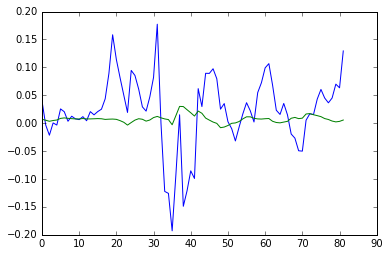

In [18]:
plt.plot(test_data.y.values)
plt.plot(predicted)

Boosted Trees Regression

In [19]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.03,
     max_depth=5, random_state=0, loss='lad').fit(train_data[use_cols].values, train_data['y'].values)
predicted = gbr.predict(test_data[use_cols].values)
rmse = np.sqrt(mean_squared_error(test_data['y'].values, predicted))

print rmse

0.0678720959169


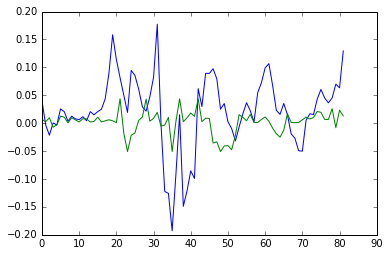

In [20]:
plt.plot(test_data.y.values)
plt.plot(predicted)

Logistic regression

In [21]:
df['y'] = (df['close'].shift(-4) / df['close'] - 1).gt(0)
# discretize columns
for c in use_cols:
    df[c] = pd.qcut(df[c].values, 10).codes

train_data = df[:int(len(df)*0.8)]
test_data = df[int(len(df)*0.8):]

sgd = SGDClassifier(loss='log')
ohenc = OneHotEncoder()
ohenc.fit(df[use_cols])
sgd.fit(ohenc.transform(train_data[use_cols].values.reshape(len(train_data), len(use_cols))), train_data['y'].values)
predicted = sgd.predict_proba(ohenc.transform(test_data[use_cols].values.reshape(len(test_data), len(use_cols))))
print predicted.mean()
print train_data['y'].mean()

0.5
0.596330275229
